In [5]:
import datetime
import matplotlib.pyplot as plt
import pandas as pd
import sklearn
from sklearn.datasets import load_diabetes
from sklearn.inspection import PartialDependenceDisplay
from sklearn.neural_network import MLPRegressor
from sklearn.pipeline import make_pipeline
from sklearn.preprocessing import StandardScaler
from sklearn.tree import DecisionTreeRegressor
import numpy as np

pd.set_option("display.max_colwidth", 0)
pd.set_option("display.max_rows", 500)
pd.set_option("display.max_columns", 500)
pd.set_option("display.width", 1000)
import warnings
warnings.filterwarnings("ignore")
pd.options.display.float_format = '{:.5f}'.format

In [6]:
import sys
import logging
import datetime

nblog = open("./logs/catboost_pdp_shap_"+str(datetime.datetime.now())+".log", "a+")
sys.stdout.echo = nblog
sys.stderr.echo = nblog

get_ipython().log.handlers[0].stream = nblog
get_ipython().log.setLevel(logging.INFO)

%autosave 5

Autosaving every 5 seconds


In [7]:
%%time
df_localness = pd.read_csv('./data/food_localness_final_oct.csv')
print('unique orders:',df_localness.shape[0])
print('unique accounts:',df_localness.account_id.unique().shape[0])
df_localness.head(2)

unique orders: 2767286
unique accounts: 555121
CPU times: user 23.1 s, sys: 11.3 s, total: 34.4 s
Wall time: 39.5 s


account_id    order_id  order_date           order_time  vendor_id         vendor_name main_cuisine vertical  delivery_fee_amount_lc  service_fee_amount_lc  basket_amount_lc is_incentive_applied  incentive_amount_lc       pickup_id  customer_lon  customer_lat  vendor_lon  vendor_lat  order_time_hour  delivery_duration  total_duration     node_id  nearest_dist1  poi1 n_vertical  n_vendor_id n_main_cuisine         n_vendor_name  n_vendor_lon  n_vendor_lat  vendor_index  pandana_distance_realdist  pandana_localness    speed  isweekend  item_price                   customer_loc_id  entropy_0.5km  poi_count_0.5km  entropy_1km  poi_count_1km  entropy_2km  poi_count_2km  entropy_3km  poi_count_3km  entropy_4km  poi_count_4km  entropy_5km  poi_count_5km  poi_count_0.5_1km  poi_count_1_2km  poi_count_2_3km  poi_count_3_4km  poi_count_4_5km  approxi_rent  compensation  discounted delivery  free delivery     gem  item discount  menu discount  voucher wallet incentives_type  \
0  7051337     1305576462  2023-10-10  2023-10-10 15:30:22  50868      SHAGHF, Jumeirah 3  coffee       food    0.00000                 1.73000                57.75000           True                10.00000             249162013.00000 55.21388      25.15585      55.23119    25.18903     15               17                 27              7584090309 0.65335         840   food       697762       coffee         Awaken Cafe, Al Wasl 55.21303      25.15146       840          4.61410                    0.14160            10.25355  False     30.06471     55.21387725.155851               0.00000        0.00000          0.47137      21.00000       0.65855      105.00000      0.66518      198.00000      0.69070      296.00000      0.70457      582.00000      21.00000           84.00000         93.00000         98.00000         286.00000        90.44289      0.00000       0.00000              0.00000        0.00000 0.00000        0.00000        10.00000         voucher wallet   
1  7051337     1313167366  2023-10-16  2023-10-16 16:43:34  50868      SHAGHF, Jumeirah 3  coffee       food    7.50000                 0.90000                26.25000           True                10.00000             250948408.00000 55.21389      25.15572      55.23119    25.18903     16               13                 31              7584090309 0.65335         840   food       697762       coffee         Awaken Cafe, Al Wasl 55.21303      25.15146       840          4.61410                    0.14160            8.93051   False     30.06471     55.213885121047525.1557155663109 0.00000        0.00000          0.47137      21.00000       0.65855      105.00000      0.66603      197.00000      0.69169      295.00000      0.70585      587.00000      21.00000           84.00000         92.00000         98.00000         292.00000        90.65273      0.00000       0.00000              0.00000        0.00000 0.00000        0.00000        10.00000         voucher wallet   

   incentive_delivery  incentive_menu_discount  incentive_voucher_wallet   rating n_rating  total_orders  consistency  
0  False               False                    True                      Amazing  None     58           0.85783       
1  False               False                    True                      Amazing  None     58           0.85783

In [5]:
# df_localness.incentive_voucher_wallet.value_counts()

In [8]:
df_localness.loc[df_localness.rating == 'Amazing', 'rating'] = '1.Amazing'
df_localness.loc[df_localness.rating == 'Very good', 'rating'] = '2.Very good'
df_localness.loc[df_localness.rating == 'Good', 'rating'] = '3.Good'
df_localness.loc[df_localness.rating == 'OK', 'rating'] = '4.OK'
df_localness.loc[df_localness.rating == 'None', 'rating'] = '5.None'

df_localness.loc[df_localness.n_rating == 'Amazing', 'n_rating'] = '1.Amazing'
df_localness.loc[df_localness.n_rating == 'Very good', 'n_rating'] = '2.Very good'
df_localness.loc[df_localness.n_rating == 'Good', 'n_rating'] = '3.Good'
df_localness.loc[df_localness.n_rating == 'OK', 'n_rating'] = '4.OK'
df_localness.loc[df_localness.n_rating == 'None', 'n_rating'] = '5.None'

df_localness.loc[df_localness.isweekend == True, 'isweekend'] = 'Yes'
df_localness.loc[df_localness.isweekend == False, 'isweekend'] = 'No'

df_localness.loc[df_localness.incentive_delivery == True, 'incentive_delivery'] = 'Yes'
df_localness.loc[df_localness.incentive_delivery == False, 'incentive_delivery'] = 'No'

df_localness.loc[df_localness.incentive_menu_discount == True, 'incentive_menu_discount'] = 'Yes'
df_localness.loc[df_localness.incentive_menu_discount == False, 'incentive_menu_discount'] = 'No'

df_localness.loc[df_localness.incentive_voucher_wallet == True, 'incentive_voucher_wallet'] = 'Yes'
df_localness.loc[df_localness.incentive_voucher_wallet == False, 'incentive_voucher_wallet'] = 'No'

In [9]:
df_localness = df_localness.rename(columns={"item_price": "price_per_item", "approxi_rent":"estimated_rent",
  "poi_count_0.5km" : "restaurant_count_0.5km", "poi_count_0.5_1km": "restaurant_count_0.5_1km",
  "poi_count_1_2km": "restaurant_count_1_2km", "poi_count_2_3km" : "restaurant_count_2_3km", 
  "poi_count_3_4km" : "restaurant_count_3_4km", "poi_count_4_5km" : "restaurant_count_4_5km"
})

In [10]:
df_features = df_localness[['basket_amount_lc','price_per_item','order_time_hour','total_duration',
                            'estimated_rent', 'entropy_0.5km','entropy_2km', 'entropy_5km', 
                            'incentive_amount_lc','incentive_delivery','incentive_menu_discount', 
                            'incentive_voucher_wallet', 'main_cuisine',
                             'isweekend', 'consistency', 'total_orders', 'rating','n_rating',
                            'restaurant_count_0.5km', 'restaurant_count_0.5_1km','restaurant_count_1_2km',
                            'restaurant_count_2_3km','restaurant_count_3_4km','restaurant_count_4_5km']]

categorical_list = ['isweekend','main_cuisine','incentive_delivery','incentive_menu_discount',
                    'incentive_voucher_wallet','rating','n_rating']

In [11]:
%%time
# check VIF
df_cor = df_features.corr()
pd.DataFrame(np.linalg.inv(df_features.corr().values), index = df_cor.index, columns=df_cor.columns)

CPU times: user 3.65 s, sys: 36.1 ms, total: 3.69 s
Wall time: 3.69 s


basket_amount_lc  price_per_item  order_time_hour  total_duration  estimated_rent  entropy_0.5km  entropy_2km  entropy_5km  incentive_amount_lc  consistency  total_orders  restaurant_count_0.5km  restaurant_count_0.5_1km  restaurant_count_1_2km  restaurant_count_2_3km  restaurant_count_3_4km  restaurant_count_4_5km
basket_amount_lc         1.13138           -0.16907        -0.04553         -0.22255        -0.06888        0.06480        0.00216      -0.02384     -0.16175             -0.02400     0.03651       0.00188                 0.01098                   0.00685                 0.01711                 0.01784                 0.00709                
price_per_item           -0.16907          1.08888         -0.02394         -0.02361        -0.06228        -0.00914       -0.01237     -0.01432     -0.17826             -0.08212     -0.04198      -0.00080                0.00111                   -0.00296                0.00484                 0.00707                 -0.00502               
order_time_hour          -0.04553          -0.02394        1.01500          -0.06514        0.04488         0.03042        -0.00672     -0.02779     -0.00369             -0.00610     0.03192       -0.00255                -0.00274                  0.01577                 0.01431                 0.02257                 0.01865                
total_duration           -0.22255          -0.02361        -0.06514         1.09150         -0.08904        -0.04147       0.05692      0.10289      -0.08706             0.00427      0.02493       0.02856                 -0.01028                  -0.02135                -0.03551                -0.02966                -0.03116               
estimated_rent           -0.06888          -0.06228        0.04488          -0.08904        1.34858         -0.15935       0.28129      -0.20525     -0.00133             0.00465      -0.02217      0.04715                 -0.11294                  -0.42966                -0.16360                -0.00678                -0.18485               
entropy_0.5km            0.06480           -0.00914        0.03042          -0.04147        -0.15935        2.61585        -0.75108     0.27763      -0.04910             0.01042      0.04161       -1.27216                -0.35137                  -0.01331                -0.14887                -0.27376                -0.07309               
entropy_2km              0.00216           -0.01237        -0.00672         0.05692         0.28129         -0.75108       2.62908      -1.03772     -0.00044             -0.02981     -0.00463      0.18343                 -0.13032                  -0.72631                -0.25739                -0.26811                0.07791                
entropy_5km              -0.02384          -0.01432        -0.02779         0.10289         -0.20525        0.27763        -1.03772     1.86702      -0.00528             -0.03699     -0.06169      -0.15823                -0.04449                  0.05253                 -0.15289                -0.08086                -0.37561               
incentive_amount_lc      -0.16175          -0.17826        -0.00369         -0.08706        -0.00133        -0.04910       -0.00044     -0.00528     1.08608              -0.01745     0.03778       -0.01376                -0.00685                  -0.00344                0.00853                 -0.00369                0.00570                
consistency              -0.02400          -0.08212        -0.00610         0.00427         0.00465         0.01042        -0.02981     -0.03699     -0.01745             1.04111      -0.17073      0.00368                 0.02241                   0.01937                 0.01188                 0.02495                 0.00832                
total_orders             0.03651           -0.04198        0.03192          0.02493         -0.02217        0.04161        -0.00463     -0.06169     0.03778              -0.17073     1.04012       -0.00211                0.00911                   -0.021

# Feature engineering

In [12]:
%%time

X = df_features
y = df_localness.pandana_localness

from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.3, random_state = 123)

# X_train.dtypes

import catboost as cb

train_dataset = cb.Pool(X_train, y_train, cat_features=categorical_list)
test_dataset = cb.Pool(X_test, y_test, cat_features=categorical_list)

CPU times: user 4.98 s, sys: 132 ms, total: 5.11 s
Wall time: 7.4 s


# Training

In [78]:
# %%time
# # ~takes 9min
# print(datetime.datetime.now(),'*************** Start running CatBoostRegressor ***************')

# regressor = cb.CatBoostRegressor(custom_metric= ['R2', 'RMSE'], early_stopping_rounds=50)
# regressor.fit(train_dataset, eval_set = test_dataset)
# output_path = './output/current_catboost_' + str(datetime.datetime.now())
# regressor.save_model(output_path)

# print(datetime.datetime.now(),'*************** Done running CatBoostRegressor ***************')

2024-06-11 13:30:58.500747 *************** Start running CatBoostRegressor ***************
Learning rate set to 0.167101
0:	learn: 0.2944434	test: 0.2945904	best: 0.2945904 (0)	total: 490ms	remaining: 8m 9s
1:	learn: 0.2860636	test: 0.2862279	best: 0.2862279 (1)	total: 891ms	remaining: 7m 24s
2:	learn: 0.2797355	test: 0.2799296	best: 0.2799296 (2)	total: 1.47s	remaining: 8m 7s
3:	learn: 0.2748366	test: 0.2750548	best: 0.2750548 (3)	total: 2.21s	remaining: 9m 10s
4:	learn: 0.2709381	test: 0.2711574	best: 0.2711574 (4)	total: 2.65s	remaining: 8m 47s
5:	learn: 0.2680168	test: 0.2682528	best: 0.2682528 (5)	total: 3.12s	remaining: 8m 37s
6:	learn: 0.2655183	test: 0.2657643	best: 0.2657643 (6)	total: 3.79s	remaining: 8m 57s
7:	learn: 0.2635732	test: 0.2638223	best: 0.2638223 (7)	total: 4.35s	remaining: 8m 59s
8:	learn: 0.2618597	test: 0.2621192	best: 0.2621192 (8)	total: 4.76s	remaining: 8m 44s
9:	learn: 0.2605222	test: 0.2608004	best: 0.2608004 (9)	total: 5.35s	remaining: 8m 49s
10:	learn: 

In [13]:
# load the trained CatBoost model
regressor = cb.CatBoostRegressor()
regressor.load_model('./output/current_catboost_2024-06-11 13:40:18.731405')

# Model evaluation

In [14]:
%%time
import numpy as np
from sklearn.metrics import mean_squared_log_error
from sklearn.metrics import mean_squared_error, r2_score

y_pred = regressor.predict(X_test)

mse = mean_squared_error(y_test, y_pred)
rmse = np.sqrt(mse)
print('Best Model RMSE: %.3f' % rmse)

r2 = r2_score(y_test, y_pred)
print('Best Model R-squared: %.3f' % r2)
# RMSLE = np.sqrt(mean_squared_log_error(y_test, y_pred) )
# Best Model RMSE: ~0.215
# Best Model R-squared: ~0.508

Best Model RMSE: 0.215
Best Model R-squared: 0.508
CPU times: user 4.11 s, sys: 0 ns, total: 4.11 s
Wall time: 911 ms


# Feature importance
## 1. Impurity importance

2024-06-14 11:35:41.468725 *************** Done running feature importance ***************
CPU times: user 14.5 s, sys: 300 ms, total: 14.8 s
Wall time: 14.6 s


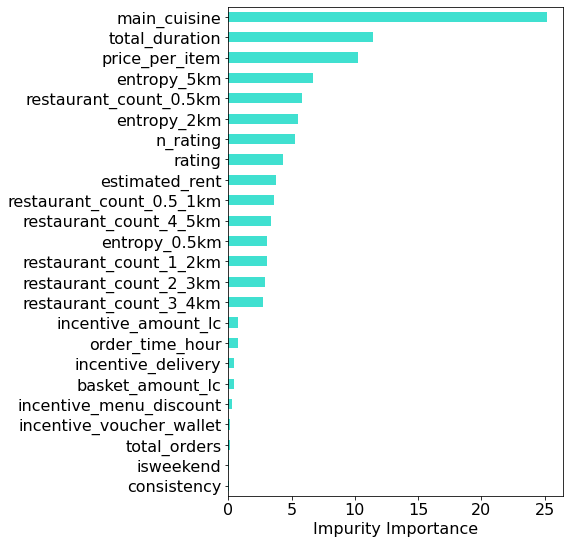

In [49]:
%%time
import matplotlib.pylab as plt
from matplotlib import pyplot

plt.rcParams.update({'font.size': 16})
fig, ax = plt.subplots(1,1,figsize=(6,9))

df_feature_importance = pd.DataFrame({'feature_importance': regressor.get_feature_importance(train_dataset), 
              'feature_names': X_test.columns}).sort_values(by=['feature_importance'], 
                                                       ascending=False)

df_feature_importance.sort_values(by=['feature_importance'], ascending=True).plot.barh(
    x='feature_names', y='feature_importance',align='center', color='turquoise',ax=ax)

# plt.xlabel("CatBoost Feature Importance")
plt.xlabel('Impurity Importance')
ax.get_legend().remove()
ax.set(ylabel=None)
plt.savefig('./output/feature_importance_impurity.pdf',bbox_inches="tight")

print(datetime.datetime.now(),'*************** Done running feature importance ***************')

## 2. Permutation importance

2024-06-14 11:30:27.961085 *************** Start running permutation_importance ***************
2024-06-14 11:33:20.854364 *************** Done running permutation_importance ***************
CPU times: user 21.2 s, sys: 4.36 s, total: 25.5 s
Wall time: 2min 52s


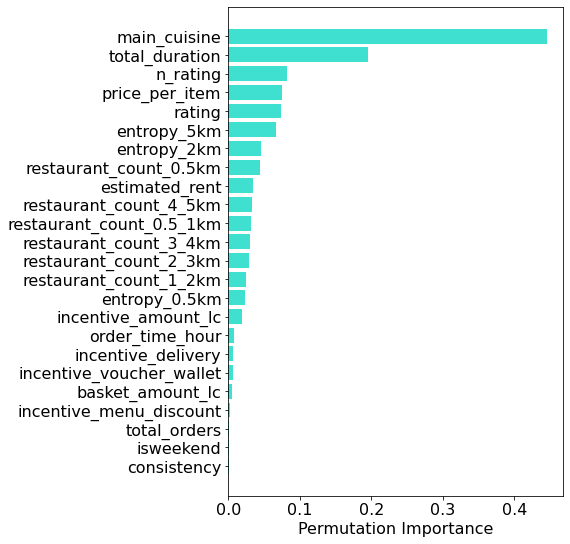

In [48]:
%%time
from sklearn.inspection import permutation_importance

print(datetime.datetime.now(),'*************** Start running permutation_importance ***************')
plt.rcParams.update({'font.size': 16})
fig, ax = plt.subplots(1,1,figsize=(6,9))
perm_importance = permutation_importance(regressor, X_train, y_train, n_repeats=10, random_state=1066, n_jobs=4)
sorted_idx = perm_importance.importances_mean.argsort()
plt.barh(range(len(sorted_idx)), perm_importance.importances_mean[sorted_idx], align='center',color='turquoise')
plt.yticks(range(len(sorted_idx)), np.array(X_train.columns)[sorted_idx])
plt.xlabel('Permutation Importance')
plt.savefig('./output/feature_importance_permutation.pdf', bbox_inches='tight')
print(datetime.datetime.now(),'*************** Done running permutation_importance ***************')

# PDP

In [15]:
feature_list_continuous= ['order_time_hour','total_duration','estimated_rent', 'entropy_0.5km','entropy_2km', 
                          'entropy_5km', 'consistency', 'total_orders', 'incentive_amount_lc',
                          'restaurant_count_0.5km', 'restaurant_count_0.5_1km','restaurant_count_1_2km',
                          'restaurant_count_2_3km','restaurant_count_3_4km','restaurant_count_4_5km',
                          'basket_amount_lc','price_per_item'
                          ]
                          
print('number of continuous features:',len(feature_list_continuous))

feature_list_cat = ['isweekend','incentive_delivery', 'incentive_menu_discount', 'incentive_voucher_wallet',
                    'rating','n_rating'] #main_cusine has too many categories so use a different code to create PDP

number of continuous features: 17


## 1. PDP for continous features

In [ ]:
# %%time 
# I tried to plot all PDP all at once but seems to trigger memory errors
# print(datetime.datetime.now(),'*************** Start running PDP: feature_list_continuous ***************')

# plt.rcParams.update({'font.size': 14})
# fig, ax = plt.subplots(figsize=(12,15))
# plt.tight_layout()
# pdp_all_continuous = PartialDependenceDisplay.from_estimator(regressor, X, feature_list_continuous, n_jobs=8, ax=ax)
# plt.subplots_adjust(top=1.2)
# plt.savefig('./output/pdp_all_continuous.pdf', bbox_inches="tight")

# print(datetime.datetime.now(),'*************** Done running PDP: feature_list_continuous ***************')

In [87]:
# %%time 
# ~50min
# print(datetime.datetime.now(),'*************** Start running PDP: feature_list_continuous ***************')

# for feature_one in ['restaurant_count_0.5km', 'restaurant_count_0.5_1km','restaurant_count_1_2km',
#     'restaurant_count_2_3km','restaurant_count_3_4km','restaurant_count_4_5km','price_per_item','estimated_rent']:
#     print(datetime.datetime.now(), feature_one)
#     plt.rcParams.update({'font.size': 14})
#     fig, ax = plt.subplots(figsize=(5,5))
#     pdp_one = PartialDependenceDisplay.from_estimator(regressor, X, [feature_one],n_jobs = 6, ax=ax)
#     plt.savefig('./output/pdp_' + feature_one + '.pdf', bbox_inches="tight")

# print(datetime.datetime.now(),'*************** Done running PDP: feature_list_continuous ***************')

2024-06-05 10:35:25.087625 *************** Start running PDP: feature_list_continuous ***************
2024-06-05 10:35:25.087803 order_time_hour
2024-06-05 10:52:14.195673 total_duration
2024-06-05 12:00:59.338159 approxi_rent
2024-06-05 13:03:40.397308 entropy_0.5km
2024-06-05 14:06:28.244514 entropy_2km
2024-06-05 15:04:02.459191 entropy_5km
2024-06-05 16:17:25.913343 consistency
2024-06-05 17:28:44.536656 total_orders
2024-06-05 18:28:54.622156 incentive_amount_lc
2024-06-05 19:29:45.677085 poi_count_0.5km
2024-06-05 20:42:55.002899 poi_count_0.5_1km
2024-06-05 22:04:36.966318 poi_count_1_2km
2024-06-05 23:27:38.211084 poi_count_2_3km
2024-06-06 00:50:19.336347 poi_count_3_4km
2024-06-06 02:07:47.200062 poi_count_4_5km
2024-06-06 03:28:23.284485 basket_amount_lc
2024-06-06 04:45:32.176725 item_price
2024-06-06 06:05:08.547695 *************** Done running PDP: feature_list_continuous ***************
CPU times: user 1min 31s, sys: 48.8 s, total: 2min 20s
Wall time: 19h 29min 43s


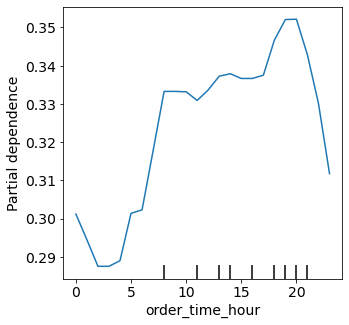

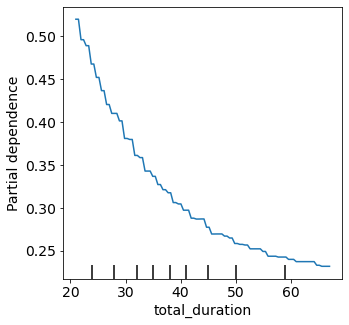

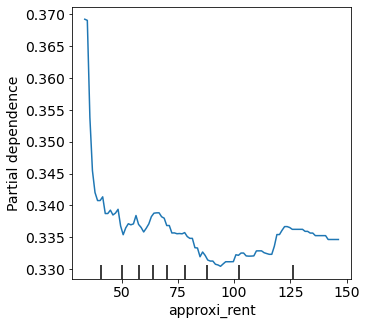

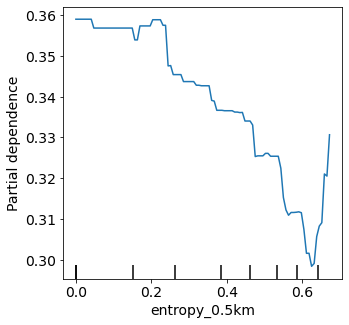

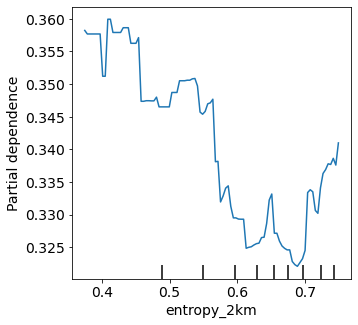

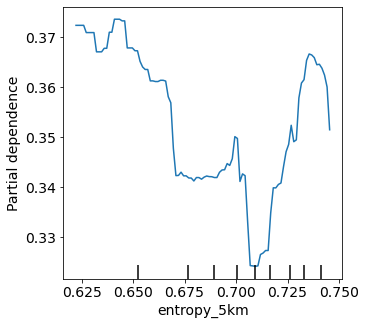

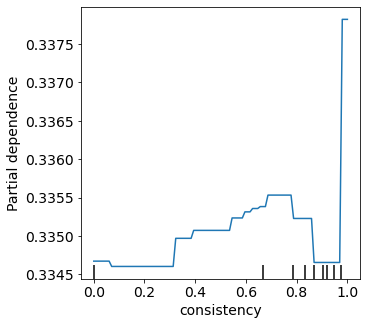

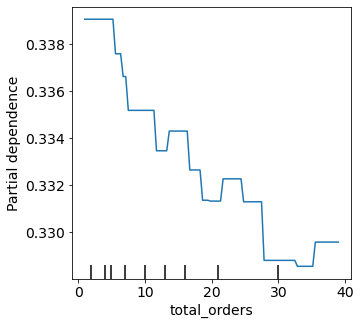

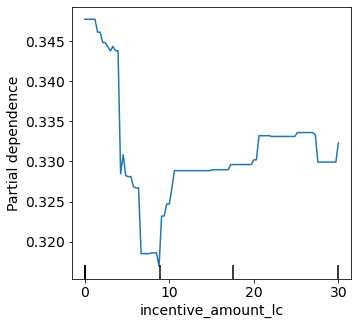

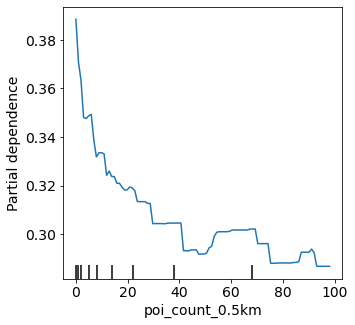

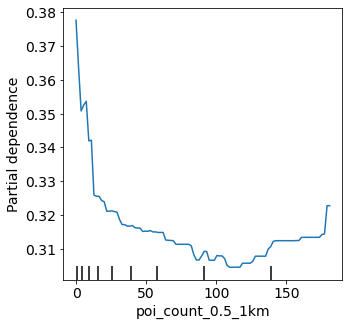

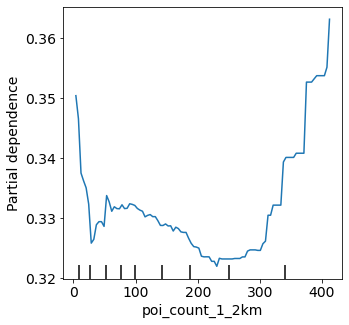

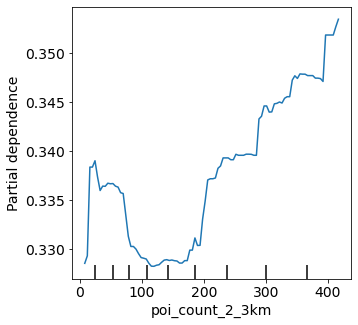

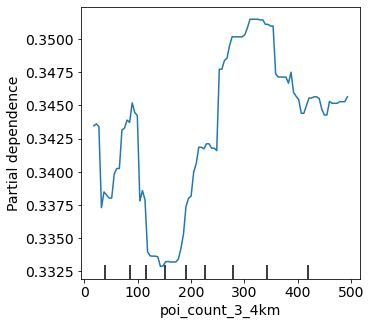

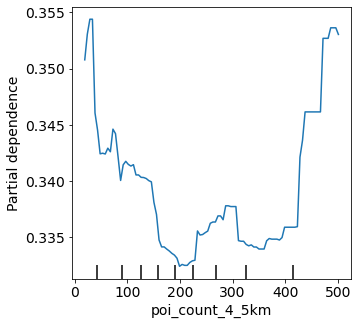

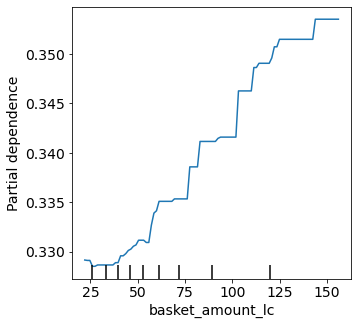

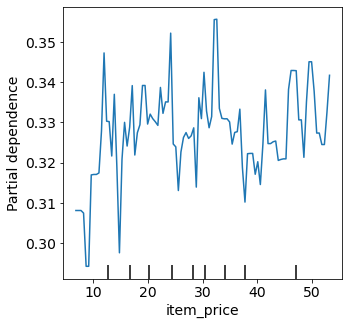

In [12]:
%%time 
# ~ 19h
# using for loop, otherwise might occur memory errors
# PDP for continuous features and save the graph for each feature separately
print(datetime.datetime.now(),'*************** Start running PDP: feature_list_continuous ***************')

for feature_one in feature_list_continuous:
    print(datetime.datetime.now(), feature_one)
    plt.rcParams.update({'font.size': 14})
    fig, ax = plt.subplots(figsize=(5,5))
    pdp_one = PartialDependenceDisplay.from_estimator(regressor, X, [feature_one],n_jobs = 6, ax=ax)
    plt.savefig('./output/pdp_' + feature_one + '.pdf', bbox_inches="tight")

print(datetime.datetime.now(),'*************** Done running PDP: feature_list_continuous ***************')

## 2. PDP for categorical features 


2024-06-11 13:43:39.257033 *************** Start running PDP: feature_list_cat ***************
2024-06-11 13:43:39.257232 isweekend
2024-06-11 13:44:03.726172 incentive_delivery
2024-06-11 13:44:19.502640 incentive_menu_discount
2024-06-11 13:44:33.965306 incentive_voucher_wallet
2024-06-11 13:44:48.992021 rating
2024-06-11 13:45:16.782137 n_rating
2024-06-11 13:45:44.362233 *************** Done running PDP: feature_list_cat ***************
CPU times: user 7.32 s, sys: 5.02 s, total: 12.3 s
Wall time: 2min 5s


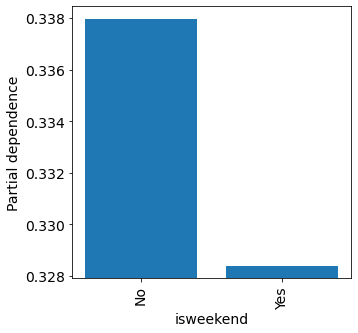

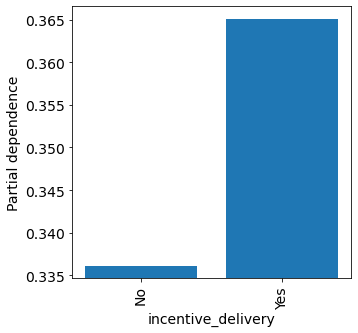

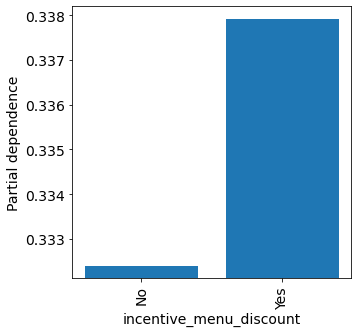

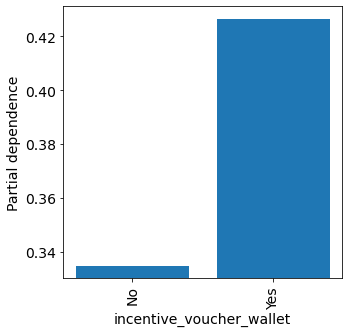

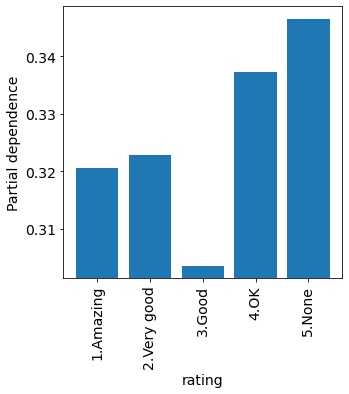

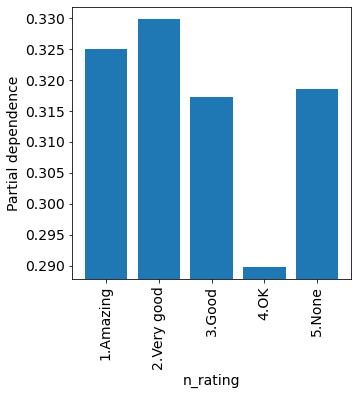

In [82]:
%%time 
# Wall time: 16min 29s
print(datetime.datetime.now(),'*************** Start running PDP: feature_list_cat ***************')

for feature_one in feature_list_cat:
    print(datetime.datetime.now(), feature_one)
    plt.rcParams.update({'font.size': 14})
    fig, ax = plt.subplots(figsize=(5,5))
    tree_disp_all = PartialDependenceDisplay.from_estimator(
        regressor, X, [feature_one], categorical_features=[feature_one], n_jobs=8 , ax=ax)
    plt.savefig('./output/pdp_'+feature_one+'.pdf',bbox_inches="tight")    

print(datetime.datetime.now(),'*************** Done running PDP: feature_list_cat ***************')

main_cusine is a huge categorical feature so create a customized graph

In [ ]:
%%time 
# ~ 21min
print(datetime.datetime.now(),'*************** Start running PDP: main_cusine ***************')

feature_select = 'main_cuisine'

plt.rcParams.update({'font.size': 14})
fig, ax = plt.subplots(figsize=(18,6))
pdp_main_cusine = PartialDependenceDisplay.from_estimator(
    regressor, X, [feature_select], categorical_features=[feature_select], n_jobs=8 ,ax=ax)
plt.savefig('./output/pdp_'+feature_select+'.pdf', bbox_inches="tight")

print(datetime.datetime.now(),'*************** Done running PDP: main_cusine ***************')

2024-06-06 17:25:40.968072 *************** Start running PDP: main_cusine ***************


In [2]:
# print(pdp_main_cusine.bars_[0][0].get_height())
# print(pdp_main_cusine.bars_[0][0].get_x())

# SHAP

In [52]:
# Using numerical encoding for categorical features so that SHAP beeswarm can color coded high and low values of categorical features
X_shap = X.copy()
X_shap.loc[X_shap.rating == '1.Amazing', 'rating'] = 5
X_shap.loc[X_shap.rating == '2.Very good', 'rating'] = 4
X_shap.loc[X_shap.rating == '3.Good', 'rating'] = 3
X_shap.loc[X_shap.rating == '4.OK', 'rating'] = 2
X_shap.loc[X_shap.rating == '5.None', 'rating'] = 1

X_shap.loc[X_shap.n_rating == '1.Amazing', 'n_rating'] = 5
X_shap.loc[X_shap.n_rating == '2.Very good', 'n_rating'] = 4
X_shap.loc[X_shap.n_rating == '3.Good', 'n_rating'] = 3
X_shap.loc[X_shap.n_rating == '4.OK', 'n_rating'] = 2
X_shap.loc[X_shap.n_rating == '5.None', 'n_rating'] = 1


X_shap.loc[X_shap.isweekend == 'Yes', 'isweekend'] = 1
X_shap.loc[X_shap.isweekend == 'No', 'isweekend'] = 0

X_shap.loc[X_shap.incentive_delivery == 'Yes', 'incentive_delivery'] = 1
X_shap.loc[X_shap.incentive_delivery == 'No', 'incentive_delivery'] = 0

X_shap.loc[X_shap.incentive_menu_discount == 'Yes', 'incentive_menu_discount'] = 1
X_shap.loc[X_shap.incentive_menu_discount == 'No', 'incentive_menu_discount'] = 0

X_shap.loc[X_shap.incentive_voucher_wallet == 'Yes', 'incentive_voucher_wallet'] = 1
X_shap.loc[X_shap.incentive_voucher_wallet == 'No', 'incentive_voucher_wallet'] = 0

In [61]:
%%time
#  ~4min
import shap
print(datetime.datetime.now(),'*************** Start running SHAP ***************')
explainer = shap.TreeExplainer(regressor)
shap_values = explainer(X_shap)
print(datetime.datetime.now(),'*************** Done running SHAP ***************')

2024-06-14 14:22:41.901051 *************** Start running SHAP ***************
2024-06-14 14:23:55.153562 *************** Done running SHAP ***************
CPU times: user 10min 59s, sys: 10.7 s, total: 11min 10s
Wall time: 1min 13s


2024-06-14 14:23:55.158469 *************** Start running SHAP importance ***************
2024-06-14 14:24:25.539114 *************** Done running SHAP importance ***************
CPU times: user 27.8 s, sys: 2.77 s, total: 30.5 s
Wall time: 30.4 s


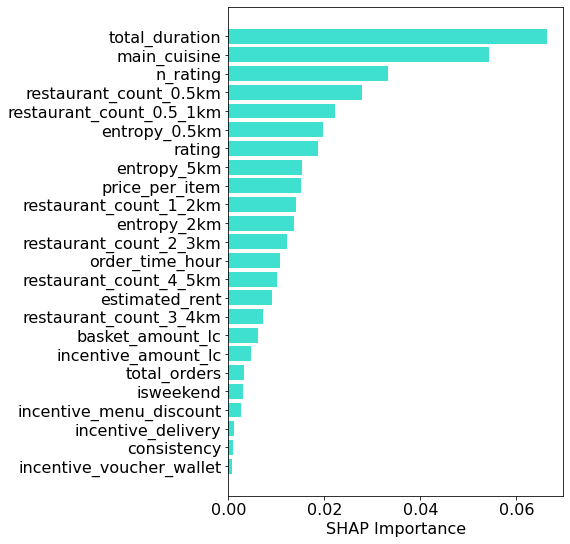

In [62]:
%%time

print(datetime.datetime.now(),'*************** Start running SHAP importance ***************')
plt.rcParams.update({'font.size': 16})
fig, ax = plt.subplots(1,1,figsize=(6,9))
shap_importance = shap_values.abs.mean(0).values
sorted_idx = shap_importance.argsort()
plt.barh(range(len(sorted_idx)), shap_importance[sorted_idx], align='center',color='turquoise')
plt.yticks(range(len(sorted_idx)), np.array(X_shap.columns)[sorted_idx])
plt.xlabel('SHAP Importance')
plt.savefig('./output/feature_importance_shap.pdf', bbox_inches='tight')
print(datetime.datetime.now(),'*************** Done running SHAP importance ***************')

In [43]:
# %%time
# # This is the visualization function offered by shap package. ~1min
# print(datetime.datetime.now(),'*************** Start running SHAP importance ***************')
# #Plot the mean absolute value of the SHAP values
# fig_shapimportance = shap.plots.bar(shap_values, max_display=50,show=False)
# plt.savefig('./output/shap_importance.pdf', bbox_inches='tight')
# print(datetime.datetime.now(),'*************** Done running SHAP importance ***************')

2024-06-14 14:24:25.656906 *************** Start running beeswarm ***************
2024-06-14 14:34:08.649701 *************** Done running beeswarm ***************
CPU times: user 9min 35s, sys: 11.9 s, total: 9min 47s
Wall time: 9min 42s


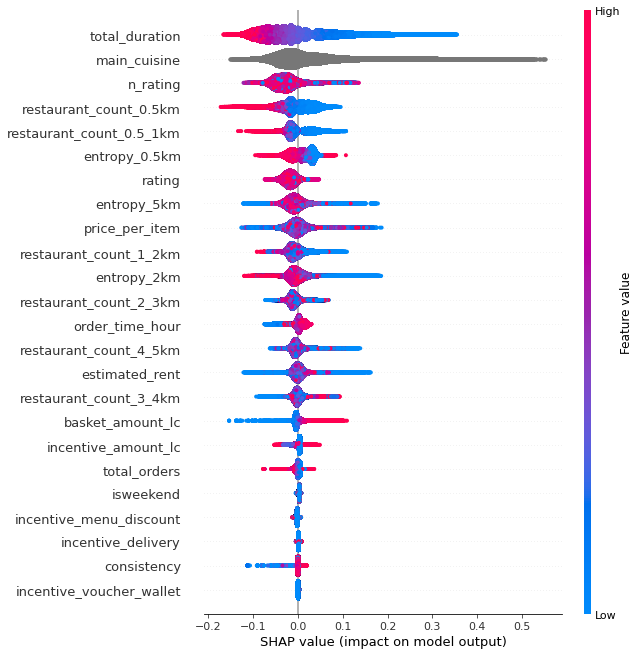

In [63]:
%%time
# ~6min
print(datetime.datetime.now(),'*************** Start running beeswarm ***************')
fig_beeswarm = shap.plots.beeswarm(shap_values,show=False, max_display=50)
plt.savefig('./output/shap_beeswarm.pdf', bbox_inches='tight')
print(datetime.datetime.now(),'*************** Done running beeswarm ***************')

## Plot interaction effects between a pair

In [17]:
def plot_shap_interaction(var1, var2):
    fig = shap.dependence_plot(var1, shap_values.values, X, dot_size=5, alpha=0.4,
                           interaction_index=var2, show=False) #, ax=ax
    plt.savefig('./output/shap_' + var1 + '_' + var2 + '.pdf',bbox_inches='tight')

In [18]:
var_interact1 = 'restaurant_count_0.5km'
var_interact2 = 'entropy_0.5km'
var_interact3 = 'estimated_rent'

feature_list_continuous_for_shap = ['basket_amount_lc','price_per_item','order_time_hour','total_duration',
  'consistency', 'total_orders', 'incentive_amount_lc', 'entropy_2km', 'entropy_5km', 'restaurant_count_0.5km',
  'restaurant_count_0.5_1km', 'restaurant_count_1_2km', 'restaurant_count_2_3km', 'restaurant_count_3_4km',
  'restaurant_count_4_5km']

In [ ]:
%%time
# ~12min var_interact1 = 'restaurant_count_0.5km'
for var in feature_list_continuous_for_shap:
    print(datetime.datetime.now(), var, var_interact1,'Running!!!')
    plot_shap_interaction(var, var_interact1)
    print(datetime.datetime.now(), var, var_interact1,'Done!!!')

2024-06-11 16:19:01.695790 basket_amount_lc restaurant_count_0.5km Running!!!
2024-06-11 16:19:47.973319 basket_amount_lc restaurant_count_0.5km Done!!!
2024-06-11 16:19:47.973945 price_per_item restaurant_count_0.5km Running!!!
2024-06-11 16:20:28.866542 price_per_item restaurant_count_0.5km Done!!!
2024-06-11 16:20:28.867147 order_time_hour restaurant_count_0.5km Running!!!
2024-06-11 16:21:12.862981 order_time_hour restaurant_count_0.5km Done!!!
2024-06-11 16:21:12.863866 total_duration restaurant_count_0.5km Running!!!
2024-06-11 16:21:53.661066 total_duration restaurant_count_0.5km Done!!!
2024-06-11 16:21:53.661689 consistency restaurant_count_0.5km Running!!!
2024-06-11 16:22:35.722919 consistency restaurant_count_0.5km Done!!!
2024-06-11 16:22:35.723529 total_orders restaurant_count_0.5km Running!!!
2024-06-11 16:23:15.693224 total_orders restaurant_count_0.5km Done!!!
2024-06-11 16:23:15.694228 incentive_amount_lc restaurant_count_0.5km Running!!!


In [ ]:
%%time
# ~12min var_interact2 = 'entropy_0.5km'
for var in feature_list_continuous_for_shap:
    print(datetime.datetime.now(), var, var_interact2,'Running!!!')
    plot_shap_interaction(var, var_interact2)
    print(datetime.datetime.now(), var, var_interact2,'Done!!!')

2024-06-12 16:38:27.595086 basket_amount_lc estimated_rent Running!!!
2024-06-12 16:38:52.522314 basket_amount_lc estimated_rent Done!!!
2024-06-12 16:38:52.522436 price_per_item estimated_rent Running!!!
2024-06-12 16:39:18.483899 price_per_item estimated_rent Done!!!
2024-06-12 16:39:18.484027 order_time_hour estimated_rent Running!!!
2024-06-12 16:39:48.361855 order_time_hour estimated_rent Done!!!
2024-06-12 16:39:48.362353 total_duration estimated_rent Running!!!
2024-06-12 16:40:23.034973 total_duration estimated_rent Done!!!
2024-06-12 16:40:23.035125 consistency estimated_rent Running!!!
2024-06-12 16:40:49.781919 consistency estimated_rent Done!!!
2024-06-12 16:40:49.782022 total_orders estimated_rent Running!!!
2024-06-12 16:41:17.021478 total_orders estimated_rent Done!!!
2024-06-12 16:41:17.021601 incentive_amount_lc estimated_rent Running!!!
2024-06-12 16:41:43.660252 incentive_amount_lc estimated_rent Done!!!
2024-06-12 16:41:43.660430 entropy_2km estimated_rent Running!!

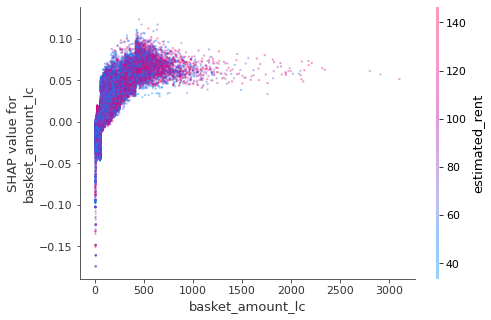

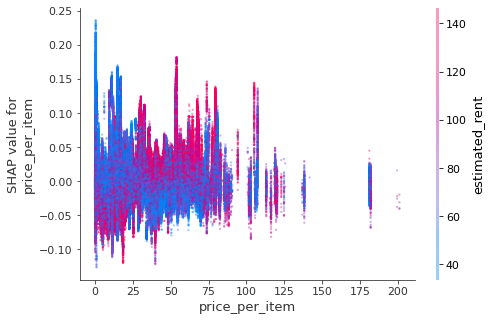

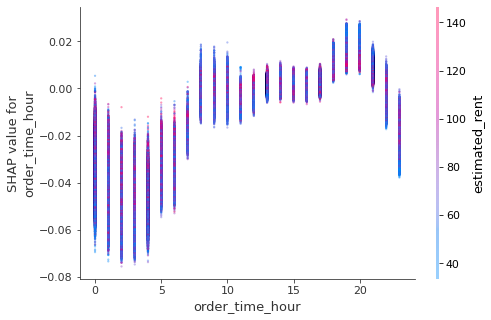

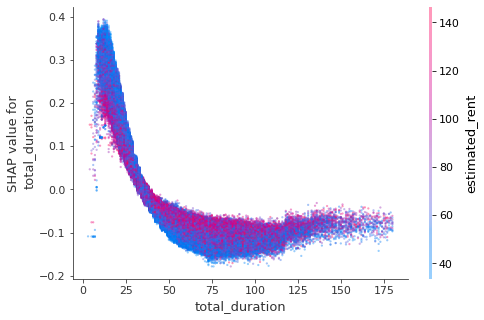

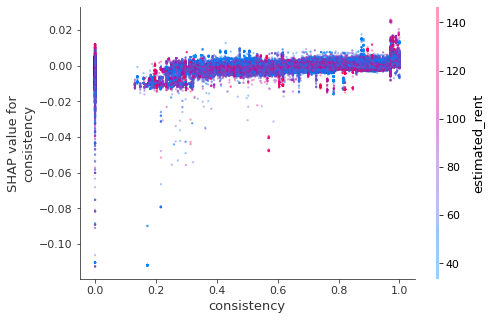

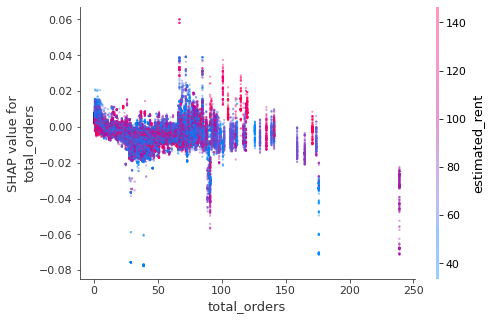

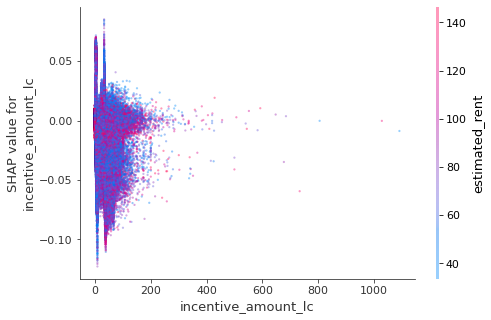

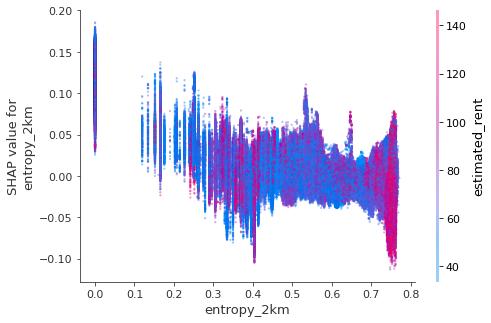

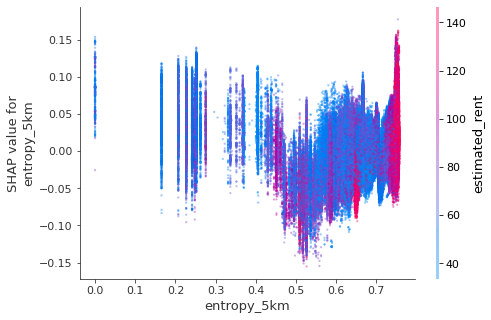

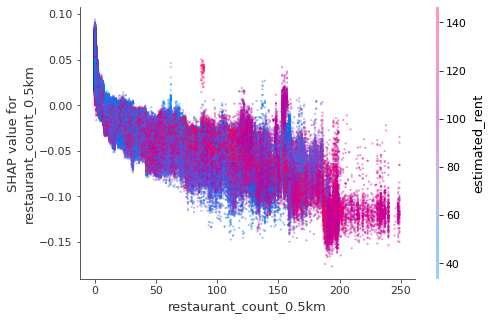

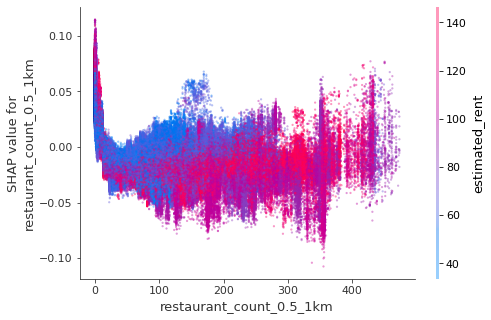

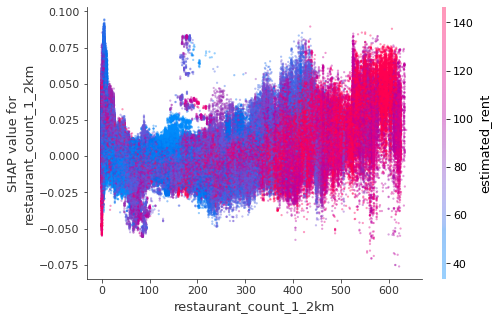

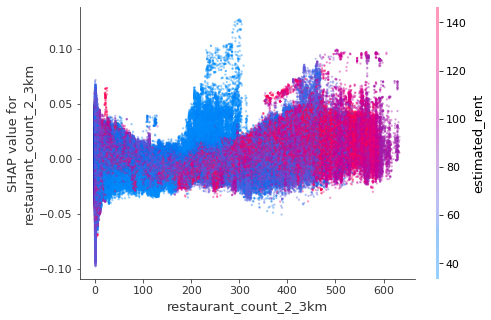

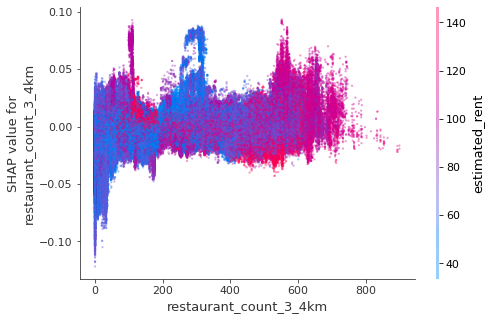

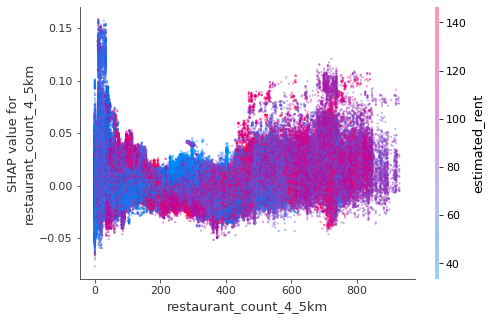

In [19]:
%%time
# ~12min var_interact3 = 'estimated_rent'
for var in feature_list_continuous_for_shap:
    print(datetime.datetime.now(), var, var_interact3,'Running!!!')
    plot_shap_interaction(var, var_interact3)
    print(datetime.datetime.now(), var, var_interact3,'Done!!!')

In [27]:
def plot_shap_interaction_onevar(var1, x_jitter1=0):
    for var2 in [var_interact1, var_interact2, var_interact3]:
        fig_incentives = shap.dependence_plot(var1, shap_values.values, X, dot_size=5, alpha=0.4,
                               interaction_index=var2, show=False, x_jitter=x_jitter1)
#         plt.xlim(xmin=0,xmax=30)
        plt.savefig('./output/shap_' + var1 + '_' + var2 + '.pdf',bbox_inches='tight')
    
def plot_shap_interaction_incentives(var1, x_jitter1=0):
    for var2 in [var_interact1, var_interact2, var_interact3]:
        fig_incentives = shap.dependence_plot(var1, shap_values.values, X, dot_size=5, alpha=0.4,
                               interaction_index=var2, show=False, x_jitter=x_jitter1)
        plt.xlim(xmin=0,xmax=30)
        plt.savefig('./output/shap_' + var1 + '_' + var2 + '.pdf',bbox_inches='tight')    

CPU times: user 1min 3s, sys: 4.97 s, total: 1min 8s
Wall time: 1min 8s


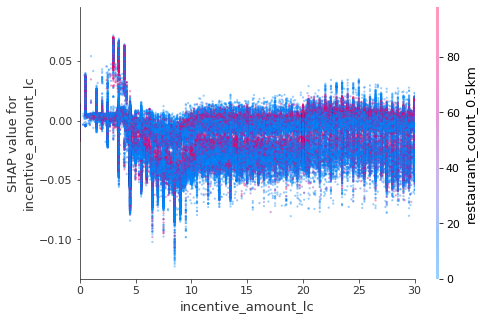

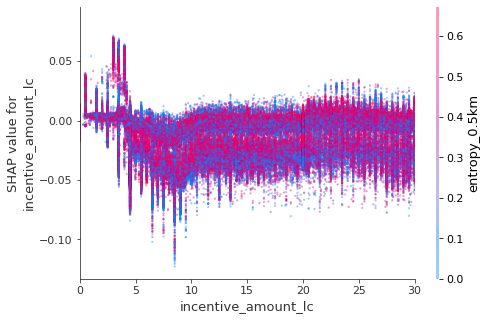

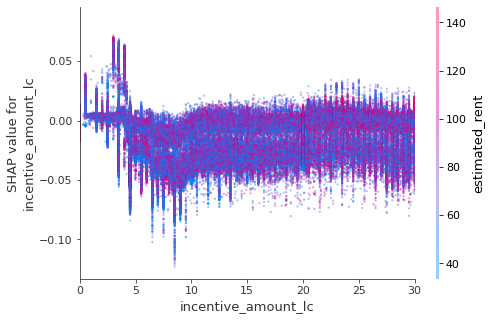

In [28]:
%%time
# set a x limit for incentive plots if needed, cancel the comment line in function plot_shap_interaction_onevar()
plot_shap_interaction_incentives('incentive_amount_lc')

In [22]:
feature_list_cat

['isweekend',
 'incentive_delivery',
 'incentive_menu_discount',
 'incentive_voucher_wallet',
 'rating',
 'n_rating']

CPU times: user 2min 15s, sys: 8.44 s, total: 2min 24s
Wall time: 2min 23s


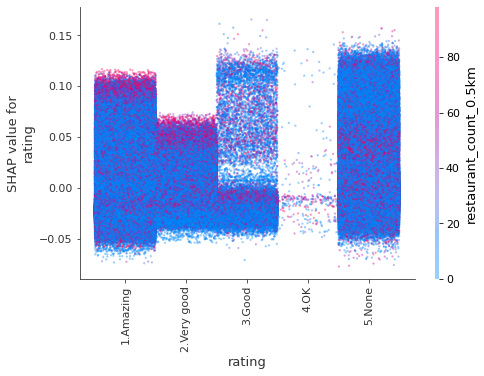

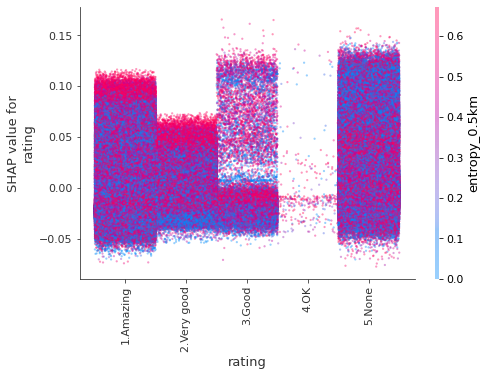

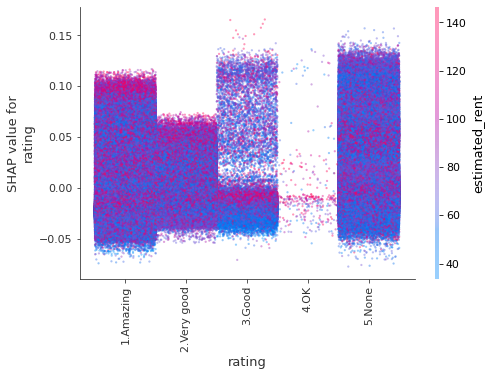

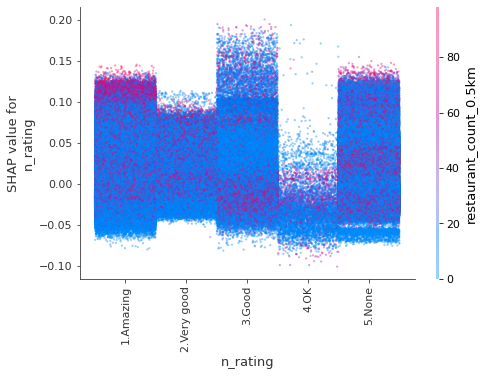

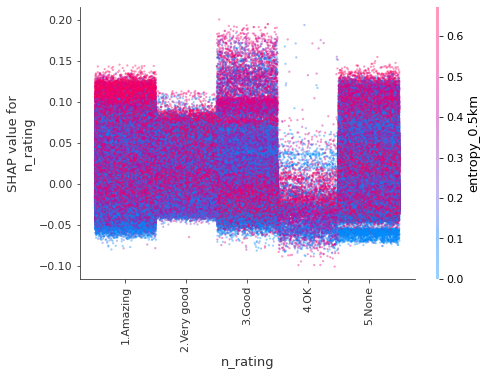

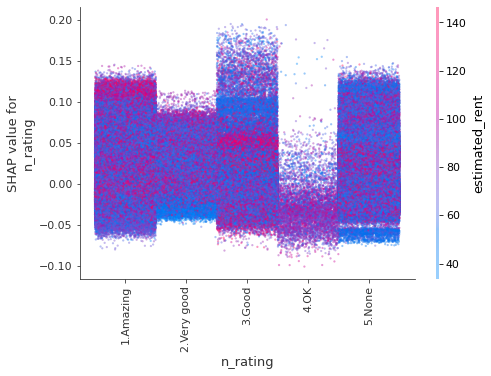

In [29]:
%%time
plot_shap_interaction_onevar('rating',x_jitter1=1)
plot_shap_interaction_onevar('n_rating',x_jitter1=1)

In [ ]:
%%time
plot_shap_interaction_onevar('order_time_hour',x_jitter1=1)
plot_shap_interaction_onevar('incentive_delivery',x_jitter1=1)
plot_shap_interaction_onevar('incentive_menu_discount',x_jitter1=1)
plot_shap_interaction_onevar('incentive_voucher_wallet',x_jitter1=1)
plot_shap_interaction_onevar('isweekend',x_jitter1=1)

## (Optional step) Most important interaction effects

In [41]:
%%time
shap.dependence_plot(0, shap_values.values, X)
# interaction_index“auto”, pick the strongest interaction
# basket amount has a bigger effect on shorter duration orders than on longer duration orders

CPU times: user 16.7 s, sys: 1.56 s, total: 18.3 s
Wall time: 24.7 s


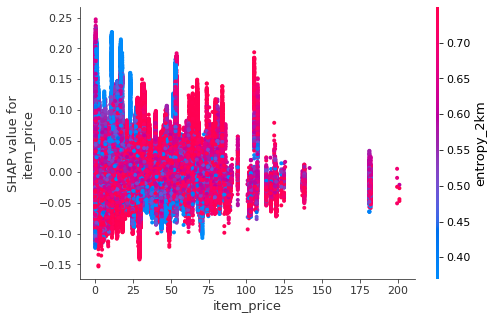

In [86]:
%%time
shap.dependence_plot(1, shap_values.values, X)